In [1]:
#!pip install tensorflow
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import scipy.io
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import clear_output
from tqdm import tqdm
from scipy.signal import savgol_filter
from keras.models import load_model

**Loading the data and creating pickle file using only one batch**


In [2]:
min_max=np.load("min_max_soc_thomas.npy")

In [3]:
df_train=pd.read_pickle("training_pount.pkl")
df_test=pd.read_pickle("testing_pount.pkl")

In [65]:
df_train["I"]=(df_train["I"]-mini)/(maxi-mini)
df_train["V"]=(df_train["V"]-minv)/(maxv-minv)
df_train["T"]=(df_train["T"]-mint)/(maxt-mint)

df_test["I"]=(df_test["I"]-mini)/(maxi-mini)
df_test["V"]=(df_test["V"]-minv)/(maxv-minv)
df_test["T"]=(df_test["T"]-mint)/(maxt-mint)

        

In [5]:
def split_sequence(sequence, input_steps, output_steps):
    X = []
    y = []
    
    for i in range(len(sequence) - input_steps - output_steps + 1):
        X.append(np.array(sequence.iloc[i:i+input_steps, :-1]))
        y.append(np.array(sequence.iloc[i+input_steps:i+input_steps+output_steps]["SOC"]))

    return X,y


In [7]:
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]
input_step=100
output_step=1 # to be chnaged to 25 incase of SOCXAI
X_train,Y_train=split_sequence(df_train,input_step,output_step)
X_test,Y_test=split_sequence(df_test,input_step,output_step)

In [82]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define CNN-Dense model
model = Sequential()

# Convolutional layers
model.add(Conv1D(16, kernel_size=3, activation='relu', input_shape=(100,3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(25, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError()])

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 98, 16)            160       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 49, 16)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                      

In [8]:
X1=np.float32(X_train)
X2=np.float32(X_test)
Y2=np.float32(Y_test)
Y1=np.float32(Y_train)


In [9]:
model2=load_model("socshaph5.h5")
for layer in model2.layers:
    if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'bias_initializer'):
        # Reinitialize kernel (weights)
        layer.kernel.assign(layer.kernel_initializer(tf.shape(layer.kernel)))
        
        # Reinitialize bias (if exists)
        if layer.bias is not None:
            layer.bias.assign(layer.bias_initializer(tf.shape(layer.bias)))

C:\Users\sarbaoui01\Anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [10]:
model2.fit(X1,Y1,verbose=1,batch_size=32,validation_data=(X2,Y2),epochs=1)

504454/504454 [==============================] - 5876s 12ms/step - loss: 0.0488 - mae: 0.0488 - mse: 0.0062 - val_loss: 0.0370 - val_mae: 0.0370 - val_mse: 0.0041


In [11]:
model2.save("soc_prediction_pount_theo.h5")

In [27]:
model=load_model("soc_prediction_pount.h5")

In [28]:
def SMAPE(forecast,actual):
    return 100/len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

In [29]:
def prepare_data(x,input_step,output_step):
    data=[]
    start=0
    end=input_step
    while (end<=len(x)):
            data.append(np.array(x.iloc[start:end,:-1]))
            end=end+output_step
            start=start+output_step
    return np.array(data)

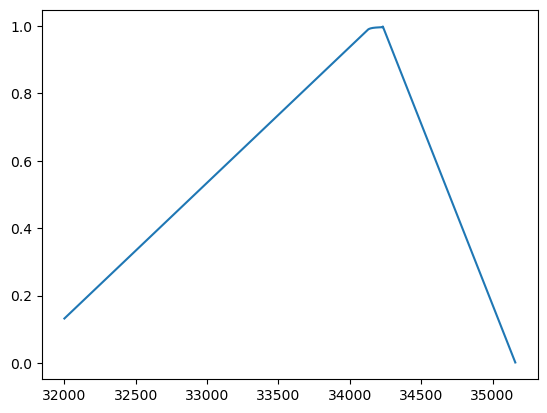

In [74]:
plt.plot(df_test["SOC"][32000:35160])

In [75]:
yp_cnn=[]
d1=df_test[2350:10559]
y1=df_test["SOC"][2350:10559]

d2=df_test[12564:15105]
y2=df_test["SOC"][12564:15105]

d3=df_test[15105:16920]
y3=df_test["SOC"][15105:16920]

d4=df_test[32000:35160]
y4=df_test["SOC"][32000:35160]

x1=prepare_data(d1,100,25)
x2=prepare_data(d2,100,25)
x3=prepare_data(d3,100,25)
x4=prepare_data(d4,100,25)

x21=prepare_data(d1,100,1)
x22=prepare_data(d2,100,1)
x23=prepare_data(d3,100,1)
x24=prepare_data(d4,100,1)



In [76]:
yp_cnn_s=[]
yp_cnn_t=[]
for i in range(len(x4)):
    yp_cnn_s.append(model.predict(np.reshape(x4[i],(1,100,3)),verbose=0)[0])
    
for i in range(len(x24)):
    yp_cnn_t.append(model2.predict(np.reshape(x24[i],(1,100,3)),verbose=0)[0])

In [77]:
yp_cnn_t=np.reshape(yp_cnn_t,(np.shape(yp_cnn_t)[0]*1))
yp_cnn_s=np.reshape(yp_cnn_s,(np.shape(yp_cnn_s)[0]*25))

In [78]:
yp_cnn_s=savgol_filter(yp_cnn_s , 32, 2)
yp_cnn_t=savgol_filter(yp_cnn_t , 32, 2)

In [79]:
time1=[]
s=0
for i in range(len(y4)):
    s=s+0.00027
    time1.append(s)
time2=[]
s=0.027
for i in range(len(yp_cnn_s)):
    s=s+0.00027
    time2.append(s)
time3=[]
s=0.027
for i in range(len(yp_cnn_t)):
    s=s+0.00027
    time3.append(s)

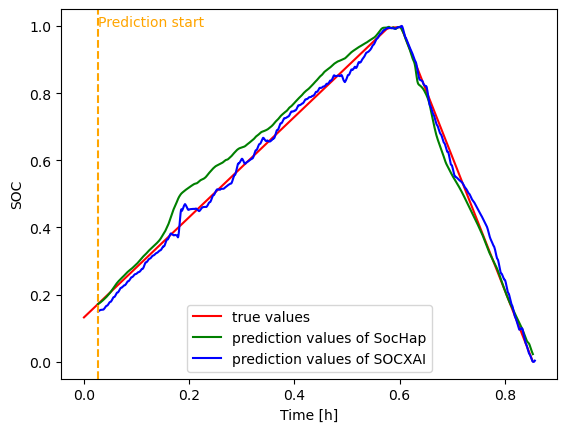

In [80]:
input_step=100
fig, ax = plt.subplots()
plt.plot(time1,np.array(y4),color="red",label="true values")
plt.plot(time3,yp_cnn_t,label="prediction values of SocHap",color="green")
plt.plot(time2,yp_cnn_s,label="prediction values of SOCXAI",color="blue")

plt.axvline(x=time1[100],color='orange', linestyle='--')
plt.text(time1[100], 1, 'Prediction start',color="orange")
plt.legend()
plt.xlabel("Time [h]")
plt.ylabel("SOC")
fig.savefig("prediction-lfp4_soc_pount.pdf", format="pdf", dpi=300,bbox_inches='tight')